In [1]:
using ForneyLab
include("sgcv/SGCV.jl")
using Main.SGCV
include("gcv/GCV.jl")
using Main.GCV
using Plots
using StatsPlots
using SparseArrays
using ProgressMeter
include("compatibility.jl") # resolves compatibility issues with ForneyLab

# Auxialry function for graph initializtion
pad(sym::Symbol, t::Int) = sym*:_*Symbol(lpad(t,3,'0')) # Left-pads a number with zeros, converts it to symbol and appends to sym

pad (generic function with 1 method)

In [2]:
# required data
using CSV, DataFrames
df = CSV.File("data/AAPL.csv") |> DataFrame
series = df[!, :Open];

### 3-L SHGF

In [3]:
# Function for generating 3-L SHGF and message-passing (MP) algorithm
function generate_mp_3l(n_cats1, n_cats2, n_samples)
    fg = FactorGraph()
    z2 = Vector{Variable}(undef, n_samples)
    s2 = Vector{Variable}(undef, n_samples)
    z1 = Vector{Variable}(undef, n_samples)
    s1 = Vector{Variable}(undef, n_samples)
    x = Vector{Variable}(undef, n_samples)
    y = Vector{Variable}(undef, n_samples)
    @RV A2 ~ Dirichlet(ones(n_cats2, n_cats2))
    @RV A1 ~ Dirichlet(ones(n_cats1, n_cats1))
    @RV ω2 ~ GaussianMeanPrecision(placeholder(:mω2, dims=(n_cats2, )), placeholder(:wω2, dims=(n_cats2, n_cats2)))
    @RV ω1 ~ GaussianMeanPrecision(placeholder(:mω1, dims=(n_cats1, )), placeholder(:wω1, dims=(n_cats1, n_cats1)))
    @RV [id=pad(:z1,1)] z1[1] ~ GaussianMeanPrecision(placeholder(:mz1_prior1), placeholder(:wz1_prior1))
    @RV [id=pad(:z2,1)] z2[1] ~ GaussianMeanPrecision(placeholder(:mz2_prior1), placeholder(:wz2_prior1))
    @RV [id=pad(:x,1)] x[1] ~ GaussianMeanPrecision(placeholder(:mx_prior1), placeholder(:wx_prior1))
    @RV [id=pad(:y,1)] y[1] ~ GaussianMeanPrecision(x[1], placeholder(:wy_prior1))
    @RV [id=pad(:s1,1)] s1[1] ~ ForneyLab.Categorical(ones(n_cats1) ./ n_cats1)
    @RV [id=pad(:s2,1)] s2[1] ~ ForneyLab.Categorical(ones(n_cats2) ./ n_cats2)
    placeholder(y[1], :y, index = 1)
    for t in 2:n_samples
        @RV [id=pad(:s2, t)] s2[t] ~ Transition(s2[t-1], A2)
        @RV [id=pad(:s1, t)] s1[t] ~ Transition(s1[t-1], A1)
        @RV [id=pad(:z2,t)] z2[t] ~ GaussianMeanPrecision(z2[t - 1], placeholder(pad(:wz2_transition, t)))
        @RV [id=pad(:z1,t)] z1[t] ~ SwitchingGaussianControlledVariance(z1[t - 1], z2[t], ones(n_cats2), ω2,s2[t])
        @RV [id=pad(:x,t)] x[t] ~ SwitchingGaussianControlledVariance(x[t - 1], z1[t], ones(n_cats1), ω1,s1[t])
        @RV [id=pad(:y,t)] y[t] ~ GaussianMeanPrecision(x[t], placeholder(pad(:wy_transition, t)))
        placeholder(y[t], :y, index = t)
    end
    q = PosteriorFactorization(x, z1, s1, z2, s2, A1, A2, ω1, ω2, ids=[:X :Z1 :S1 :Z2 :S2 :A1 :A2 :Ω1 :Ω2])
    algo = messagePassingAlgorithm(free_energy=true)
    src_code = algorithmSourceCode(algo, free_energy=true);
    return src_code
end

# Function for running MP-based inference for 3-L SHGF
function mp_3l(obs;
    n_cats1, n_cats2,
    n_its = 20,
    wy_prior1 = 1.0,
    κ1_m_prior = ones(n_cats1),
    ω1_m_prior = omegas1,
    κ1_w_prior =  huge .* diageye(n_cats1),
    ω1_w_prior = 1.0 * diageye(n_cats1),
    z1_m_prior = 0.0,
    z1_w_prior = 1.0,
    κ2_m_prior = ones(n_cats2),
    ω2_m_prior = omegas2,
    κ2_w_prior =  huge .* diageye(n_cats2),
    ω2_w_prior = 1.0 * diageye(n_cats2),
    z2_m_prior = 0.0,
    z2_w_prior = 1.0,
    x_m_prior = 0.0,
    x_w_prior = 1.0,
    x_x_m_prior = zeros(n_cats1),
    x_x_w_prior = 1.0*diageye(n_cats1),
    z1_z1_m_prior = zeros(n_cats1),
    z1_z1_w_prior = 1.0*diageye(n_cats1),
    z1_w_transition_prior = 1000.0,
    z2_z2_m_prior = zeros(n_cats2),
    z2_z2_w_prior = 1.0*diageye(n_cats2),
    z2_w_transition_prior = 10.0,
    y_w_transition_prior =  1/mnv,
)
    n_samples = length(obs)
    marginals = Dict()

    # second  layer
    marginals[:A1] = ProbabilityDistribution(ForneyLab.MatrixVariate, Dirichlet, a=ones(n_cats1, n_cats1))
    marginals[:κ1] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m = κ1_m_prior, w = κ1_w_prior)
    marginals[:ω1] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m = ω1_m_prior, w = ω1_w_prior)
    marginals[pad(:z1,1)] = vague(GaussianMeanPrecision)

    # third layer
    marginals[:A2] = ProbabilityDistribution(ForneyLab.MatrixVariate, Dirichlet, a=ones(n_cats2, n_cats2))
    marginals[:κ2] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m = κ2_m_prior, w = κ2_w_prior)
    marginals[:ω2] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m = ω2_m_prior, w = ω2_w_prior)
    marginals[pad(:z2,1)] = vague(GaussianMeanPrecision)

    marginals[pad(:x,1)] = vague(GaussianMeanPrecision)
    marginals[pad(:s1,1)] = vague(Categorical, n_cats1)
    marginals[pad(:s2,1)] = vague(Categorical, n_cats2)
    for t = 2:n_samples
        marginals[pad(:z1,t)] = ProbabilityDistribution(ForneyLab.Univariate, GaussianMeanPrecision, m = z1_m_prior, w = z1_w_prior)
        marginals[pad(:z2,t)] = ProbabilityDistribution(ForneyLab.Univariate, GaussianMeanPrecision, m = z2_m_prior, w = z2_w_prior)
        marginals[pad(:x,t)] = ProbabilityDistribution(ForneyLab.Univariate, GaussianMeanPrecision, m = x_m_prior, w = x_w_prior)
        marginals[pad(:s1,t)] = ProbabilityDistribution(Categorical, p = ones(n_cats1) ./ n_cats1)
        marginals[pad(:s2,t)] = ProbabilityDistribution(Categorical, p = ones(n_cats2) ./ n_cats2)
        marginals[pad(:s1,t)*:_*pad(:s1,t-1)] = ProbabilityDistribution(Contingency,p=ones(n_cats1, n_cats1) ./ n_cats1)
        marginals[pad(:s2,t)*:_*pad(:s2,t-1)] = ProbabilityDistribution(Contingency,p=ones(n_cats2, n_cats2) ./ n_cats2)
        marginals[pad(:z1,t)*:_*pad(:z1,t-1)] = ProbabilityDistribution(ForneyLab.Multivariate,GaussianMeanPrecision, m = z1_z1_m_prior, w = z2_z2_m_prior)
        marginals[pad(:z2,t)*:_*pad(:z2,t-1)] = ProbabilityDistribution(ForneyLab.Multivariate,GaussianMeanPrecision, m = z2_z2_m_prior, w = z2_z2_w_prior)
        marginals[pad(:x,t)*:_*pad(:x,t-1)] = ProbabilityDistribution(ForneyLab.Multivariate,GaussianMeanPrecision, m = x_x_m_prior, w = x_x_w_prior)
    end
    data = Dict()
    data[:y] = obs
    data[:mz1_prior1] = z1_m_prior
    data[:wz1_prior1] = z1_w_prior
    data[:mz2_prior1] = z2_m_prior
    data[:wz2_prior1] = z2_w_prior
    data[:mx_prior1] = x_m_prior
    data[:wx_prior1] = x_w_prior
    data[:wy_prior1] = wy_prior1
    data[:mω1] = ω1_m_prior
    data[:mω2] = ω2_m_prior
    data[:wω1] = ω1_w_prior
    data[:wω2] = ω2_w_prior
    for t = 1:n_samples
        data[pad(:wz1_transition, t)] = z1_w_transition_prior
        data[pad(:wz2_transition, t)] = z2_w_transition_prior
        data[pad(:wy_transition, t)] = y_w_transition_prior
    end


    fe = Vector{Float64}(undef, n_its)

    @showprogress "Iterations" for i = 1:n_its

        stepX!(data, marginals)
        stepS1!(data, marginals)
        stepA1!(data, marginals)
        stepΩ1!(data, marginals)
        stepZ1!(data, marginals)
        stepS2!(data, marginals)
        stepA2!(data, marginals)
        stepΩ2!(data, marginals)
        stepZ2!(data, marginals)

        fe[i] = freeEnergy(data, marginals)
    end

    mz1 = [ForneyLab.unsafeMean(marginals[pad(:z1,t)]) for t=1:n_samples]
    vz1 = [ForneyLab.unsafeVar(marginals[pad(:z1,t)]) for t=1:n_samples]
    mω1 = ForneyLab.unsafeMean(marginals[:ω1])
    vω1 = ForneyLab.unsafeCov(marginals[:ω1])
    mz2 = [ForneyLab.unsafeMean(marginals[pad(:z2,t)]) for t=1:n_samples]
    vz2 = [ForneyLab.unsafeVar(marginals[pad(:z2,t)]) for t=1:n_samples]
    mω2 = ForneyLab.unsafeMean(marginals[:ω2])
    vω2 = ForneyLab.unsafeCov(marginals[:ω2])
    mx = [ForneyLab.unsafeMean(marginals[pad(:x,t)]) for t=1:n_samples]
    vx = [ForneyLab.unsafeVar(marginals[pad(:x,t)]) for t=1:n_samples]
    ms1 = [ForneyLab.unsafeMean(marginals[pad(:s1,t)]) for t=1:n_samples]
    ms2 = [ForneyLab.unsafeMean(marginals[pad(:s2,t)]) for t=1:n_samples]
    return mz1, vz1, mω1, vω1, mz2, vz2, mω2, vω2, mx, vx, ms1, ms2, fe
end

mp_3l (generic function with 1 method)

In [4]:
omegas1 = [-1.0, 4.0]
omegas2 = [-3.0, 1.0]

2-element Vector{Float64}:
 -3.0
  1.0

In [5]:
code = generate_mp_3l(2, 2, length(series))
eval(Meta.parse(code))

freeEnergy (generic function with 1 method)

In [6]:
mz1, vz1, mω1, vω1, mz2, vz2, mω2, vω2, mx1, vx1, ms1, ms2, fe2 = mp_3l(series, n_its = 100, n_cats1=2, n_cats2=2,
                                                                        x_m_prior=series[1],
                                                                        ω1_m_prior=omegas1, ω2_m_prior=omegas2,
                                                                        ω1_w_prior = 1.0 * diageye(2),
                                                                        ω2_w_prior = 10.0 * diageye(2),
                                                                        z1_w_transition_prior = 100.0,
                                                                        z1_w_prior = 100.0,
                                                                        z2_w_prior = 100.0,
                                                                        y_w_transition_prior=1.0)

results =   Dict("mz1" => mz1, "vz1" => vz1,
                 "mz2" => mz2, "vz2" => vz2,
                 "mx1" => mx1, "vx" => vx1,
                 "ms1" => ms1, "ms2" => ms2,
                 "fe" => fe2,
                 "mω1" => mω1, "vω1" => vω1,
                 "mω2" => mω2, "vω2" => vω2,
                 "ωprior1" => omegas1,
                 "ωprior2" => omegas2)

Iterations 100%|█████████████████████████████████████████| Time: 0:00:33


Dict{String, Array} with 15 entries:
  "mz2"     => [0.00174429, 0.0191872, 0.0207422, 0.0152358, 0.00743231, -0.000…
  "mω1"     => [0.701811, 2.93863]
  "mx1"     => [65.8435, 66.4086, 66.4168, 66.4513, 66.2549, 65.4653, 65.6189, …
  "fe"      => [885.734, 727.662, 697.359, 683.563, 670.37, 659.604, 653.246, 6…
  "ms1"     => [[0.863506, 0.136494], [0.94478, 0.0552201], [0.977159, 0.022840…
  "vω1"     => [0.00996447 -0.0; -0.0 0.0361578]
  "mz1"     => [-0.0163059, -0.174275, -0.299892, -0.398675, -0.475741, -0.5342…
  "vz1"     => [0.00979131, 0.0830404, 0.130216, 0.16105, 0.17977, 0.188481, 0.…
  "vx"      => [0.413091, 0.516619, 0.4996, 0.480685, 0.466263, 0.453588, 0.442…
  "mω2"     => [-2.34021, 0.994968]
  "ωprior1" => [-1.0, 4.0]
  "vω2"     => [0.00704132 -0.0; -0.0 0.0999714]
  "ms2"     => [[0.646864, 0.353136], [0.965998, 0.0340017], [0.996425, 0.00357…
  "vz2"     => [0.00979899, 0.0856776, 0.134091, 0.165537, 0.186243, 0.199869, …
  "ωprior2" => [-3.0, 1.0]

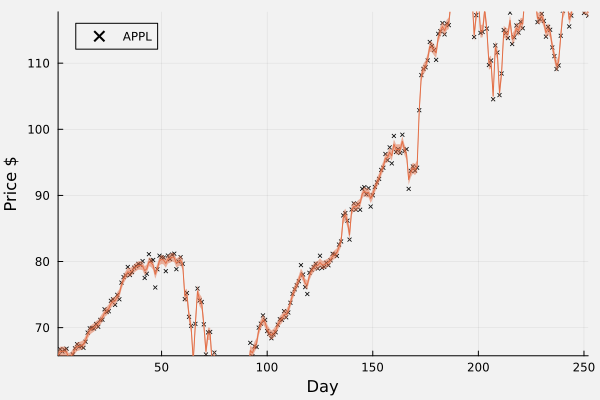

In [7]:
xlims_ = 1, length(series)
switch_line = 52
shift = 0.1
scatter(series, background_color=:grey95, xlabel=:Day, ylabel="Price \$", label="APPL", markershape=:xcross, markersize=2, markeralpha=1.0, color=:black)
plot!(mx1, ribbon=sqrt.(vx1), label=false)
scatter!(switch_line*ones(length(ms1)), color=argmax.(ms1), markersize=5.0, markeralpha=0.5, label=false)
xlims!(xlims_)
ylims!(mx1[xlims_[1]]-shift, mx1[xlims_[2]]+shift)

In [8]:
using JLD
JLD.save("dump/results_3shgf_stocks_mixture.jld","results",results)

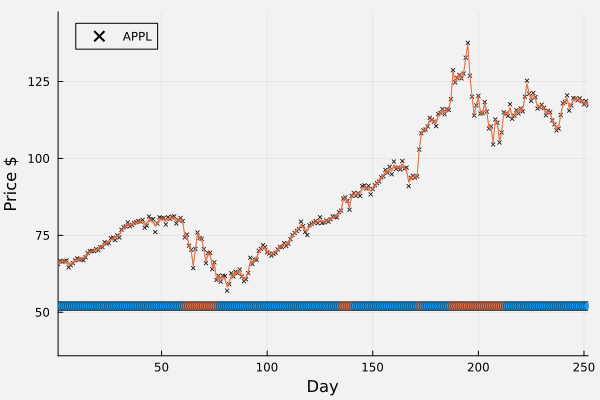

In [9]:
xlims_ = 1, length(series)
switch_line = 52
shift = 30.0
scatter(series, background_color=:grey95, xlabel=:Day, ylabel="Price \$", label="APPL", markershape=:xcross, markersize=2, markeralpha=1.0, color=:black)
plot!(mx1, ribbon=sqrt.(vx1), label=false)
scatter!(switch_line*ones(length(ms1)), color=argmax.(ms1), markersize=5.0, markeralpha=0.5, label=false)
xlims!(xlims_)
ylims!(mx1[xlims_[1]]-shift, mx1[xlims_[2]]+shift)
